# Exploratory Data Analysis (EDA)
## SKU-Level Analytics Mart

This notebook explores a SKU-level analytics mart built from cleaned
product dimensions and aggregated Amazon and International sales data.

Objectives:
- Understand sales coverage and missingness
- Analyze demand and revenue distributions
- Compare channel and category performance
- Justify the downstream machine learning approach

All monetary values are in the same currency as the source data.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("E:\sku_analytics_mart.csv")


## Dataset Overview

In [41]:
df.shape

(9185, 12)

In [42]:
df.head()

,product_id,sku,design_no,category,size,color,intl_units_sold,intl_revenue,intl_avg_price,amazon_units_sold,amazon_revenue,amazon_avg_price
0,1,J0289-KR-L,J0289,Kurta,L,Black,NaN,NaN,NaN,NaN,NaN,NaN
1,2,JNE3796-KR-XXL,JNE3796,Kurta,XXL,Peach,NaN,NaN,NaN,3.0,1363.57,345.000000
2,3,J0117-TP-M,J0117,Top,M,White,44719.0,461.0,426.095000,90.0,57745.15,590.311111
3,4,AN210-NAVY-L,AN210,An : Leggings,L,Navy Blue,NaN,NaN,NaN,NaN,NaN,NaN
4,5,SET269-KR-NP-XXL,SET269,Set,XXL,Green,581975.0,6108.0,968.979167,35.0,29261.71,791.885714


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9185 entries, 0 to 9184
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         9185 non-null   int64  
 1   sku                9185 non-null   object 
 2   design_no          9185 non-null   object 
 3   category           9185 non-null   object 
 4   size               9185 non-null   object 
 5   color              9185 non-null   object 
 6   intl_units_sold    4495 non-null   float64
 7   intl_revenue       4495 non-null   float64
 8   intl_avg_price     4495 non-null   float64
 9   amazon_units_sold  6618 non-null   float64
 10  amazon_revenue     6587 non-null   float64
 11  amazon_avg_price   6563 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 861.2+ KB


## Conclusion (Dataset Overview):

The analytics mart contains 9,184 SKUs with 12 columns, including product attributes and aggregated sales metrics for Amazon and International channels. 

Product attributes (sku, design_no, category, size, color) are complete with 0 missing values, which makes this dataset reliable for segmentation and category-level comparisons. 


## Missing Values and Structural Nulls

In [44]:
df.isnull().sum()

product_id              0
sku                     0
design_no               0
category                0
size                    0
color                   0
intl_units_sold      4690
intl_revenue         4690
intl_avg_price       4690
amazon_units_sold    2567
amazon_revenue       2598
amazon_avg_price     2622
dtype: int64

## Conclusion (Missing Values and Structural Nulls):

Missing values appear only in sales metric columns and represent structural missingness (i.e., the SKU exists in the product catalog but has no sales in that channel). 

International sales metrics are missing for 4,689 SKUs, while Amazon metrics are missing for ~2,566–2,621 SKUs depending on the metric. These nulls should be treated as “no activity” for units/revenue (filled with 0), while average prices should remain null when there were no sales.


## Sales Coverage by Channel

In [45]:
sales_zero_cols = [
    "intl_units_sold", "intl_revenue",
    "amazon_units_sold", "amazon_revenue"
]

df[sales_zero_cols] = df[sales_zero_cols].fillna(0)


In [46]:
df["sold_intl"] = df["intl_units_sold"] > 0
df["sold_amazon"] = df["amazon_units_sold"] > 0
df["sold_both"] = df["sold_intl"] & df["sold_amazon"]
df["sold_anywhere"] = df["sold_intl"] | df["sold_amazon"]


In [47]:
df[["sold_anywhere","sold_amazon","sold_intl","sold_both"]].mean()
df["sold_anywhere"].value_counts()

sold_anywhere
True     7393
False    1792
Name: count, dtype: int64

In [48]:
df["sold_anywhere"].value_counts()
df[["sold_amazon", "sold_intl", "sold_both"]].mean()


sold_amazon    0.715188
sold_intl      0.489385
sold_both      0.399673
dtype: float64

In [49]:
df_eda = df.copy()
df_ml = df[df["sold_anywhere"]].copy()

In [50]:
df_ml[["sold_amazon", "sold_intl"]].mean()

sold_amazon    0.888543
sold_intl      0.608008
dtype: float64

In [51]:
df_ml = df[df["sold_anywhere"]].copy()

# Fill structural nulls for sales metrics (already done, but safe)
sales_zero_cols = ["intl_units_sold","intl_revenue","amazon_units_sold","amazon_revenue"]
df_ml[sales_zero_cols] = df_ml[sales_zero_cols].fillna(0)

# Keep avg prices as NaN; create safe versions for modeling
df_ml["amazon_avg_price_f"] = df_ml["amazon_avg_price"].fillna(0)
df_ml["intl_avg_price_f"] = df_ml["intl_avg_price"].fillna(0)

# Optional: log-transform heavy-tailed metrics
for c in ["intl_units_sold","intl_revenue","amazon_units_sold","amazon_revenue"]:
    df_ml[f"log_{c}"] = np.log1p(df_ml[c])

In [52]:
num_features = [
    "log_intl_units_sold",
    "log_intl_revenue",
    "log_amazon_units_sold",
    "log_amazon_revenue",
    "amazon_avg_price_f",
    "intl_avg_price_f",
]

In [53]:
df_ml[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
log_intl_units_sold,7393.0,7.367029,5.950778,0.0,0.000000,11.319353,12.303658,14.862632
log_intl_revenue,7393.0,4.668020,3.812980,0.0,0.000000,6.783325,7.872836,10.910953
log_amazon_units_sold,7393.0,1.946700,1.223268,0.0,1.098612,1.945910,2.772589,6.495266
log_amazon_revenue,7393.0,7.405458,2.945677,0.0,6.857514,8.066835,9.178643,13.176284
amazon_avg_price_f,7393.0,541.829007,320.047250,0.0,348.333333,517.000000,713.000000,2598.000000
intl_avg_price_f,7393.0,465.576106,468.067852,0.0,0.000000,462.000000,741.000000,3239.000000


In [54]:
df_eda[["sold_amazon", "sold_intl", "sold_both"]].sum()

sold_amazon    6569
sold_intl      4495
sold_both      3671
dtype: int64

In [55]:
df_eda["sold_anywhere"].value_counts(normalize=True)

sold_anywhere
True     0.804899
False    0.195101
Name: proportion, dtype: float64

## Conclusion (Sales Coverage):

About 80.5% of SKUs recorded sales in at least one channel, while 19.5% of SKUs had no sales during the observed period. 

Amazon shows broader SKU coverage (6,569 SKUs) than international sales (4,495 SKUs). A total of 3,671 SKUs sold in both channels, indicating meaningful overlap but also significant channel-specific assortment.

## Distribution of Units Sold

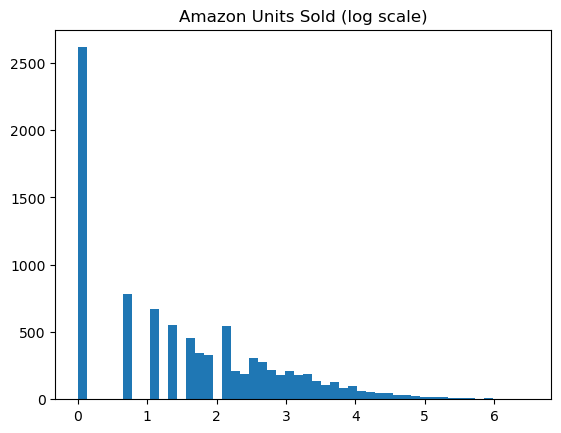

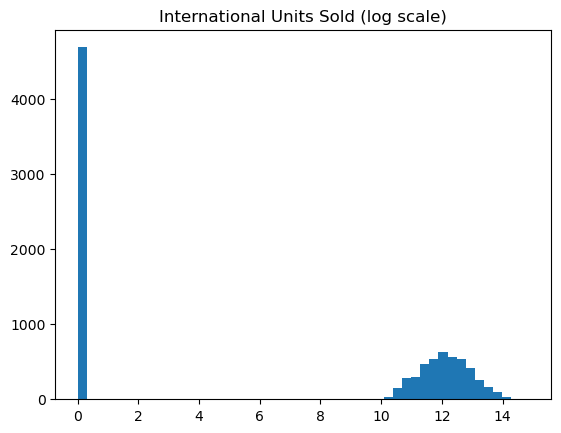

In [56]:
plt.hist(np.log1p(df["amazon_units_sold"]), bins=50)
plt.title("Amazon Units Sold (log scale)")
plt.show()

plt.hist(np.log1p(df["intl_units_sold"]), bins=50)
plt.title("International Units Sold (log scale)")
plt.show()


## Conclusion (Units Sold Distribution):

Units sold are highly skewed, with most SKUs selling low volumes and a small number of SKUs selling very high volumes (long-tail behavior). This pattern is typical in retail and supports using log-scaled plots for interpretation

## Distribution of Revenue

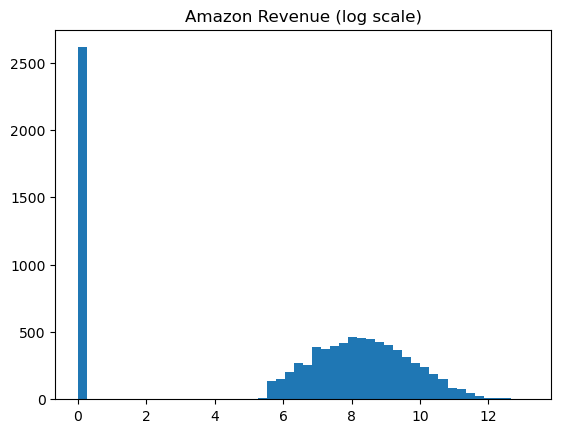

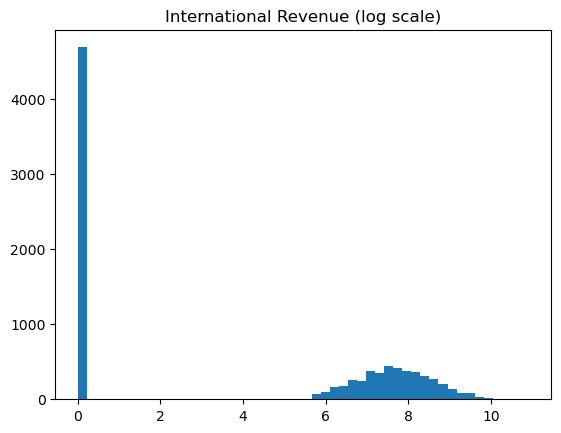

In [57]:
plt.hist(np.log1p(df["amazon_revenue"]), bins=50)
plt.title("Amazon Revenue (log scale)")
plt.show()

plt.hist(np.log1p(df["intl_revenue"]), bins=50)
plt.title("International Revenue (log scale)")
plt.show()


## Conclusion (Revenue Distribution):

Revenue distributions are also strongly right-skewed, meaning a small subset of SKUs contributes disproportionately to total revenue. This confirms that aggregate performance is driven by a limited number of high-performing items. 

## Revenue Concentration (Long-Tail Analysis)

In [58]:
def revenue_concentration(df, col):
    s = df[col].sort_values(ascending=False)
    cum_pct = s.cumsum() / s.sum()
    return (cum_pct <= 0.8).mean()

print("Amazon revenue — % of SKUs driving 80%:",
      revenue_concentration(df_eda, "amazon_revenue"))

print("International revenue — % of SKUs driving 80%:",
      revenue_concentration(df_eda, "intl_revenue"))

Amazon revenue — % of SKUs driving 80%: 0.19912901469787697
International revenue — % of SKUs driving 80%: 0.23102885138813284


## Conclusion (Revenue Concentration):

Approximately ~19.9% of SKUs contribute 80% of Amazon revenue, and ~23.1% of SKUs contribute 80% of international revenue. 

This confirms a classic long-tail pattern: revenue is concentrated among a minority of SKUs, which motivates SKU segmentation and prioritization strategies (e.g., focusing inventory and marketing on top contributors). 

## Category Performance

In [59]:
cat_summary = (
    df_eda
    .groupby("category")[["amazon_revenue", "intl_revenue"]]
    .sum()
    .sort_values("amazon_revenue", ascending=False)
)

cat_summary.head(10)

,amazon_revenue,intl_revenue
category,,
Kurta Set,24878283.51,5206028.0
Kurta,23193948.27,4884643.0
Set,11207074.68,1284146.0
Dress,7757139.03,937709.0
Top,3762987.71,1094561.0
Night Wear,1174443.84,101319.0
Tunic,787604.57,367457.0
Lehenga Choli,532630.57,82876.0
Blouse,425648.18,62127.0


## Conclusion (Category Performance):

The top revenue-driving categories in Amazon include Kurta Set, Kurta, Set, Dress, and Top, each generating substantial revenue across channels. 

Several of these leading categories also contribute meaningfully to international revenue, indicating that core product categories have multi-channel demand—though magnitude varies by channel.

## Channel Mix by Category

In [60]:
cat_summary["amazon_share"] = (
    cat_summary["amazon_revenue"] /
    (cat_summary["amazon_revenue"] + cat_summary["intl_revenue"])
)

cat_summary.sort_values("amazon_share", ascending=False).head(10)


,amazon_revenue,intl_revenue,amazon_share
category,,,
Bottom,349.00,0.0,1.000000
Kurti,16771.43,0.0,1.000000
Cardigan,10047.90,0.0,1.000000
Crop Top With Plazzo,388149.10,3556.0,0.990922
Jumpsuit,13559.00,681.0,0.952177
Night Wear,1174443.84,101319.0,0.920582
Set,11207074.68,1284146.0,0.897196
Dress,7757139.03,937709.0,0.892153
Blouse,425648.18,62127.0,0.872632


## Conclusion (Channel Mix by Category):

Category channel mix is not uniform. Some categories appear almost entirely Amazon-driven (e.g., categories with amazon_share near 1.0 such as Bottom, Kurti, Cardigan), while others show more balanced contributions. 

For meaningful interpretation, categories with extremely low total revenue should be treated carefully (a 100% Amazon share on a very small revenue base is not strategically significant).

## Both Channels vs Single Channel

In [61]:
df_eda.groupby("sold_both")[["amazon_units_sold", "amazon_revenue"]].mean()

,amazon_units_sold,amazon_revenue
sold_both,,
False,6.897715,4697.045930
True,19.526287,13231.097889


## Conclusion (Both vs Single Channel):

SKUs that sell in both channels substantially outperform single-channel SKUs on average:

Average Amazon units sold: 19.53 (both-channel) vs 6.90 (single-channel)

Average Amazon revenue: 13,231 (both-channel) vs 4,698 (single-channel) 

This suggests that cross-channel presence is associated with stronger demand and higher revenue potential, making “both-channel SKUs” a strong candidate segment for prioritization.

## EDA Summary and Modeling Direction

The dataset contains 9,184 SKUs with complete product attributes and channel-level aggregated sales metrics. 

Roughly 80.5% of SKUs recorded sales in at least one channel; 19.5% had no sales during the period. 

Amazon covers more SKUs (6,569) than international (4,495), with 3,671 SKUs selling in both channels. 

Sales and revenue exhibit a long-tail distribution, with a small portion of SKUs driving most revenue. 

About ~20% of SKUs drive 80% of Amazon revenue; ~23% drive 80% of international revenue—supporting segmentation and prioritization analysis. 

Category performance differs by channel; some categories are strongly Amazon-weighted, but small categories must be interpreted cautiously. 

SKUs selling in both channels show much higher average Amazon units and revenue than single-channel SKUs, suggesting cross-channel presence is associated with higher performance. 

Modeling direction: A SKU-level dataset with strong long-tail patterns is well-suited for SKU segmentation (clustering) and/or classification (e.g., predicting “both-channel” vs “single-channel”SKUs). True demand forecasting would require time-series features (e.g., monthly SKU sales), which are not present in this aggregated mart. 